In [10]:
%matplotlib inline

Index(['demand-7', 'demand-10', 'demand-12'], dtype='object')
0.028702659603040952


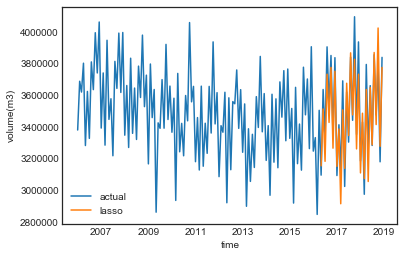

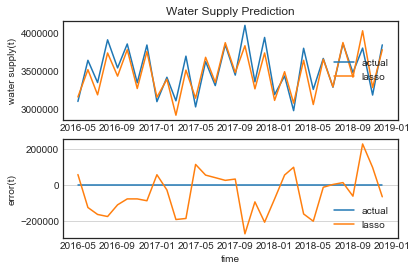

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
import xgboost
import datetime as dt
import statsmodels.api as sm
import itertools
plt.style.use('seaborn-white')
from statsmodels.tsa.arima_model import ARIMA

finalDataDf = pd.read_csv('MyData12.csv')
finalData = finalDataDf.values
X = finalData[:,:-1]
y = finalData[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)




numTest = len(y_test)
numTrain = 1 - numTest

vec_date = np.vectorize(dt.date)

t = vec_date(X[:,0], X[:,1], 1)
t_test = vec_date(X_test[:, 0], X_test[:, 1], 1)
allFig = plt.figure()
allFigax = allFig.add_subplot(111)
allFigax.plot_date(t, y, '-', label='actual')
allFigax.legend(loc='upper right')
allFigax.set_xlabel("time")
allFigax.set_ylabel('volume(m3)')

#%% algorithm


#%% feature selection

lassoIC = LassoLarsIC()
lassoIC.fit(X_train, y_train)
coef = lassoIC.coef_
X = X[:,coef!=0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)

coef = np.append(coef,0)
print(finalDataDf.columns[coef!=0])

di = {'feature':finalDataDf.columns[coef!=0], 'coef':coef[coef!=0]}
selectedFeature = pd.DataFrame(data=di)

selectedFeature = pd.DataFrame(data=coef[coef!=0], index=finalDataDf.columns[coef!=0], columns=['coef'])
selectedFeature.sort_values(by=['coef'],ascending=0).to_csv("featureCoef.csv")

#%% test plot

fig = plt.figure()
ax = fig.add_subplot(211)
plt.plot_date(t_test, y_test,'-', label='actual')
plt.legend(loc='upper right')

plt.ylabel('water supply(t)')
plt.title('Water Supply Prediction')

predAll = []

ax2 = fig.add_subplot(212)
plt.plot_date(t_test, y_test-y_test,'-', label='actual')
plt.grid(axis="y")
plt.ylabel('error(t)')
plt.xlabel('time')

def draw_prediction(predictions, y_test, mName):
    
    res = predictions - y_test
    ax.plot_date(t_test, predictions,'-', label=mName)
    ax.legend(loc='best')
    ax2.plot_date(t_test, res, '-', label=mName)
    ax2.legend(loc='best')
    
    allFigax.plot_date(t_test, predictions,'-', label=mName)
    allFigax.legend(loc='best')
    # np.mean(abs(y_train_pred - y_train))/np.mean(y_train)
    print(np.mean(abs(res))/np.mean(y_test))
#%% feature normalization

m = X_train.mean(axis=0)
s = X_train.std(axis=0)
X_train = ( X_train - m ) / s
X_test = ( X_test - m ) / s

#%% lasso regression
"""
lassocv.alplha_ is different from which in R
"""

mName = 'lasso'
lassocv = LassoLarsIC()
lassocv.fit(X_train, y_train)
y_train_pred = lassocv.predict(X_train)
predictions = lassocv.predict(X_test)
predAll = np.append(predAll,predictions).reshape([-1,1])
coef = lassocv.coef_
lassocv.alpha_

draw_prediction(predictions, y_test, mName)